# Part I. Code replication

Packages and data load

In [1]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install scipy
# %pip install tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

np.random.seed(2026)

# url="https://raw.githubusercontent.com/avril-rdgz/SCEDS_TVMA/refs/heads/main/predictors_data.csv"
# df = pd.read_csv(url)
# df.head()

Model

In [30]:
def DGP1(T, J, R2, alpha=1.5):
    c = np.sqrt(R2 / (1 - R2))

    t = np.arange(1, T + 1)
    tau = t / T
    F_tau = tau**3

    X = np.random.randn(T, J)
    X[:, 0] = 1.0
    j = np.arange(1, J+1)
    theta = c * np.sqrt(2 * alpha) * j**(-(alpha + 0.5))
    mu = F_tau * (X @ theta)
    eps = np.random.randn(T)
    Y = mu + eps

    return Y, X, mu

# def DGP2(T, J, R2, alpha=1.5):
#     c = np.sqrt(R2 / (1 - R2))

#     t = np.arange(1, T + 1)
#     tau = t / T
#     F_tau = np.array([1 if x>0.3 else 0.5 for x in tau])

#     X = np.random.randn(T, J)
#     X[:, 0] = 1.0
#     j = np.arange(1, J+1)
#     theta = c * np.sqrt(2 * alpha) * j**(-(alpha + 0.5))
#     mu = F_tau * (X @ theta)
#     eps = np.random.randn(T)
#     Y = mu + eps

#     return Y, X, mu


def DGP2(T, J, R2, alpha=1.5):
    c = np.sqrt(R2 / (1 - R2))

    t = np.arange(1, T + 1)
    tau = t / T

    F_tau = np.where(tau < 0.3, 0.1,
                     np.where(tau < 0.8, 1.0, -0.5))

    X = np.random.randn(T, J)
    X[:, 0] = 1.0

    j = np.arange(1, J+1)
    theta = c * np.sqrt(2 * alpha) * j**(-(alpha + 0.5))

    mu = F_tau * (X @ theta)
    eps = np.random.randn(T)

    Y = mu + eps
    return Y, X, mu

In [31]:
y1, _, _  = DGP1(100, 100, 0.5)

In [32]:
y2, _, _  = DGP2(100, 100, 0.5)

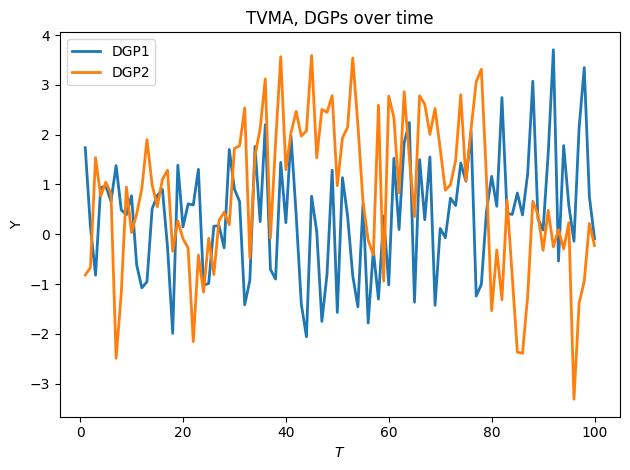

In [33]:
T = 100
plt.plot(np.arange(1, T + 1), y1, linewidth=2, label='DGP1')
plt.plot(np.arange(1, T + 1), y2, linewidth=2, label='DGP2')



plt.xlabel(r"$T$")
plt.ylabel("Y")
plt.title(f"TVMA, DGPs over time")
plt.legend()
plt.tight_layout()
plt.show()

Methodology: Estimator

c = 0.33: θ_j falls below tolerance=1e-03 at j = 24
c = 0.68: θ_j falls below tolerance=1e-03 at j = 35
c = 1.00: θ_j falls below tolerance=1e-03 at j = 42
c = 1.53: θ_j falls below tolerance=1e-03 at j = 52
c = 3.00: θ_j falls below tolerance=1e-03 at j = 73


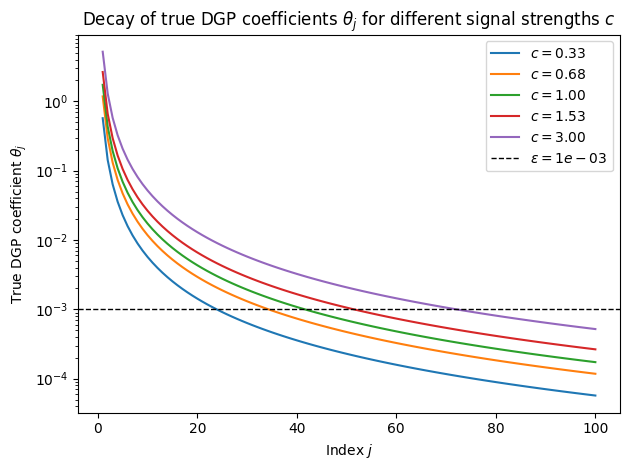

In [34]:

def check_true_dgp(alpha=1.5, eps=1e-3):
    j = np.arange(1, 101)
    # c values implied by R^2 in [0.1, 0.9]
    cs = [0.33, 0.68, 1.00, 1.53, 3.00]

    for c in cs:
        theta = c * np.sqrt(2 * alpha) * j**(-(alpha + 0.5))
        # find first index where theta_j <= eps since theta is monotonically decreasing
        fail_idx = np.where(theta <= eps)[0]

        if len(fail_idx) == 0:
            print(f"c = {c:.2f}: θ_j remains above tolerance={eps:.0e} for all j ≤ {j[-1]}")
        else:
            j_star = j[fail_idx[0]]
            print(f"c = {c:.2f}: θ_j falls below tolerance={eps:.0e} at j = {j_star}")
        plt.plot(j, theta, label=fr"$c = {c:.2f}$")
    plt.axhline(eps, color="black", linestyle="--", linewidth=1, label=fr"$\varepsilon = {eps:.0e}$")
    plt.xlabel(r"Index $j$")
    plt.ylabel(r"True DGP coefficient $\theta_j$")
    plt.title(r"Decay of true DGP coefficients $\theta_j$ for different signal strengths $c$")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()
check_true_dgp()

In [35]:
def ls_oracle_mse(mu_hat_mat, mu_true):

    M = mu_hat_mat.shape[1]

    def obj(w):
        mu_w = mu_hat_mat @ w
        return np.mean((mu_w - mu_true)**2)

    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: w}
    )

    w0 = np.full(M, 1.0 / M)
    res = minimize(obj, w0, constraints=cons, method='SLSQP')
    mu_oracle = mu_hat_mat @ res.x

    return np.mean((mu_oracle - mu_true)**2)


In [36]:

def kernel_vec(t, T, h):
    s = np.arange(1, T + 1) # Epanechnikov
    u = (s - t) / (T * h)
    k = 0.75 * (1 - u**2)
    k[np.abs(u) > 1] = 0.0
    return k

def local_jackknife(Y, X, h):
    T = len(Y); mu_tilde = np.empty(T)
    for i in range(T):
        t = i+1
        K = kernel_vec(t, T, h)
        K[i] = 0.0
        W = np.diag(K)
        beta = np.linalg.solve(X.T @ W @ X, X.T @ W @ Y)
        mu_tilde[i] = X[i, :] @ beta
    return mu_tilde

def local_estimator(Y, X, h):
    T = len(Y); mu_hat = np.empty(T)
    for i in range(T):
        t = i+1
        K = kernel_vec(t, T, h)
        # K[i] = 0.0
        W = np.diag(K)
        beta = np.linalg.solve(X.T @ W @ X, X.T @ W @ Y)
        mu_hat[i] = X[i, :] @ beta
    return mu_hat

def obj_cv(w, mu_mat, Y, K):
    mu_w = mu_mat @ w
    resid = Y - mu_w
    return np.sum(resid**2 * K)

def compute_optimal_weights(mu_mat, mu_true):
    M = mu_mat.shape[1]

    # Objective: minimize squared error
    def obj(w):
        mu_w = mu_mat @ w
        return np.mean((mu_true - mu_w)**2)

    # Constraints: sum of weights = 1, weights >= 0
    cons = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type':'ineq', 'fun': lambda w: w})

    w0 = np.full(M, 1./M)
    res = minimize(obj, w0, constraints=cons, method='SLSQP', options={'ftol':1e-12})
    return res.x

def tvjma(Y, X_list, h):
    T, M = len(Y), len(X_list)
    # Local estimator
    mu_hat_mat = np.empty((T, M))
    for m, X in enumerate(X_list):
        mu_hat_mat[:, m] = local_estimator(Y, X, h)
    # Jackknife Prediction
    mu_tilde_mat = np.empty((T, M))
    for m, X in enumerate(X_list):
        mu_tilde_mat[:, m] = local_jackknife(Y, X, h)

    # Optimization for time varying weights with kernel fct & obj_cv (with mu tilde)
    w_hat = np.zeros((T, M)); mu_hat = np.empty(T)
    for i in range(T):
        t = i+1
        K = kernel_vec(t, T, h)
        # K[i] = 0.0
        cons = ({'type':'eq','fun':lambda w: np.sum(w)-1},
                {'type':'ineq','fun':lambda w: w})
        w0 = np.full(M, 1./M) # initial value = uniform
        res = minimize(obj_cv, w0, args=(mu_tilde_mat, Y, K),
                       method='SLSQP', constraints=cons,
                       options={'ftol':1e-9})
        w_hat[i] = res.x
        mu_hat[i] = mu_hat_mat[i] @ w_hat[i]
    return mu_hat, mu_hat_mat, mu_tilde_mat, w_hat

def build_X_list(X):
    T, J = X.shape
    X_list = []

    for m in range(1, J + 1):
        X_list.append(X[:, :m])

    return X_list


def monte_carlo(T, R2, dgp_num, h, n_rep=1000):
    MSE_inf_all = []   # will store lowest MSE across candidate models per replication
    MSE_tvjma_all = []    # will store MSE of TVJMA per replication
    J = int(np.round(3 * T**(1/3)))

    for r in (range(n_rep)):
        if dgp_num == 1:
            Y, X, mu_true = DGP1(T, 100, R2)
        elif dgp_num == 2:
            Y, X, mu_true = DGP2(T, 100, R2)
        else:
            raise ValueError("dgp must be 'DGP1' or 'DGP2'")

        X = X[:, :J]
        X_list = build_X_list(X)
        mu_tvma, mu_hat_mat, mu_tilde_mat, w_hat = tvjma(Y, X_list, h)

        M = len(X_list)
        mu_hat_ls = np.empty((T, M))

        for m, Xm in enumerate(X_list):
            beta_ls = np.linalg.lstsq(Xm, Y, rcond=None)[0]
            mu_hat_ls[:, m] = Xm @ beta_ls

        mse_oracle = ls_oracle_mse(mu_hat_ls, mu_true)
        MSE_inf_all.append(mse_oracle)

            # TVJMA risk
        mse_tvjma = np.mean((mu_tvma - mu_true)**2)
        MSE_tvjma_all.append(mse_tvjma)

    # Convert to numpy arrays
    MSE_inf_all = np.array(MSE_inf_all)
    MSE_tvjma_all = np.array(MSE_tvjma_all)

    normalized_risk = MSE_tvjma_all.mean() / MSE_inf_all.mean()

    return normalized_risk, mu_tvma[26]


100%|██████████| 9/9 [03:18<00:00, 22.03s/it]


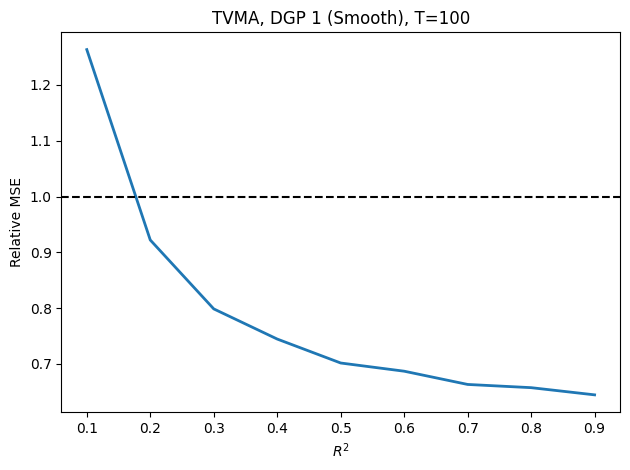

In [19]:

T = 100
R2_grid = np.arange(0.1, 1.0, 0.1)
rel_mse = np.zeros(len(R2_grid))
mu = np.zeros(len(R2_grid))

for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse[i], mu[i] = monte_carlo(T, R2, dgp_num = 1, h = 2.34*T**(-0.2), n_rep=100)

plt.plot(R2_grid, rel_mse, linewidth=2)
plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title(f"TVMA, DGP 1 (Smooth), T={T}")
plt.tight_layout()
plt.show()

Methodology: Comparison

In [38]:
T = 100
R2_grid = np.arange(0.1, 1.0, 0.1)
rel_mse_01 = np.zeros(len(R2_grid))
rel_mse_03 = np.zeros(len(R2_grid))
rel_mse_05 = np.zeros(len(R2_grid))
rel_mse_07 = np.zeros(len(R2_grid))
rel_mse_09 = np.zeros(len(R2_grid))

mu_01 = np.zeros(len(R2_grid))
mu_03 = np.zeros(len(R2_grid))
mu_05 = np.zeros(len(R2_grid))
mu_07 = np.zeros(len(R2_grid))
mu_09 = np.zeros(len(R2_grid))

In [39]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_01[i], mu_01[i]  = monte_carlo(T, R2, dgp_num=2, h=0.2, n_rep=100)

100%|██████████| 9/9 [00:20<00:00,  2.32s/it]


In [40]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_03[i], mu_03[i] = monte_carlo(T, R2, dgp_num=2, h=0.4, n_rep=100)

100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


In [41]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_05[i], mu_05[i] = monte_carlo(T, R2, dgp_num=2, h=0.6, n_rep=100)

100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


In [42]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_07[i], mu_07[i] = monte_carlo(T, R2, dgp_num=2, h=0.8, n_rep=100)

100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


In [43]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_09[i], mu_09[i] = monte_carlo(T, R2, dgp_num=2, h=1.0, n_rep=100)

100%|██████████| 9/9 [00:19<00:00,  2.17s/it]


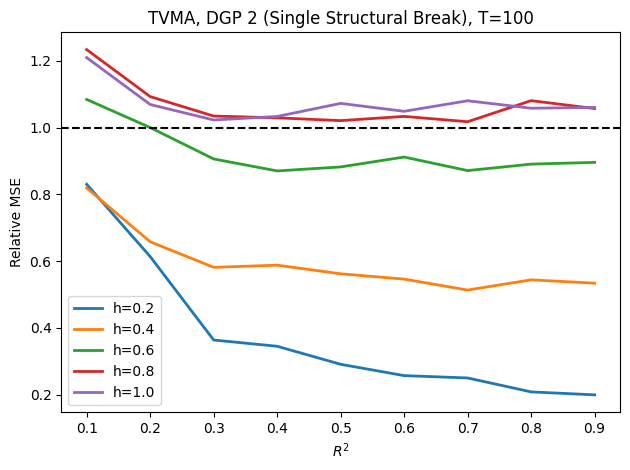

/tmp/ipykernel_961/1081633915.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


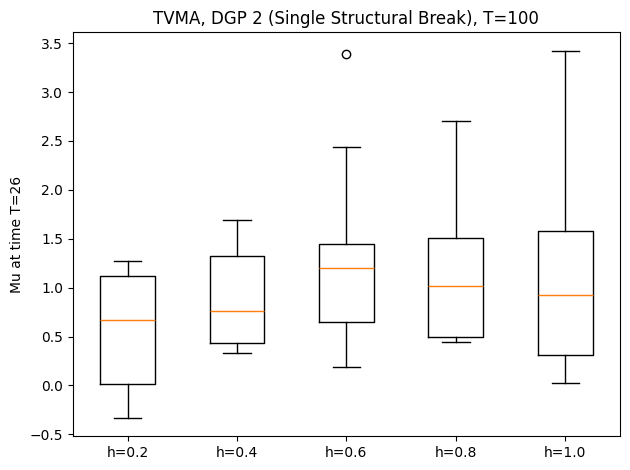

In [46]:
plt.plot(R2_grid, rel_mse_01, linewidth=2, label='h=0.2')
plt.plot(R2_grid, rel_mse_03, linewidth=2, label='h=0.4')
plt.plot(R2_grid, rel_mse_05, linewidth=2, label='h=0.6')
plt.plot(R2_grid, rel_mse_07, linewidth=2, label='h=0.8')
plt.plot(R2_grid, rel_mse_09, linewidth=2, label='h=1.0')

plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title(f"TVMA, DGP 2 (Single Structural Break), T={100}")
plt.legend()
plt.tight_layout()
plt.show()

data = [mu_01, mu_03, mu_05, mu_07, mu_09]
labels = ['h=0.2', 'h=0.4', 'h=0.6', 'h=0.8', 'h=1.0']

plt.figure()
plt.boxplot(data, labels=labels, showfliers=True)
plt.ylabel("Mu at time T=26")
plt.title(r"TVMA, DGP 2 (Single Structural Break), T=100")
plt.tight_layout()
plt.show()

In [47]:
# DGP 1
rel_mse_11 = np.zeros(len(R2_grid))
rel_mse_13 = np.zeros(len(R2_grid))
rel_mse_15 = np.zeros(len(R2_grid))
rel_mse_17 = np.zeros(len(R2_grid))
rel_mse_19 = np.zeros(len(R2_grid))

mu_11 = np.zeros(len(R2_grid))
mu_13 = np.zeros(len(R2_grid))
mu_15 = np.zeros(len(R2_grid))
mu_17 = np.zeros(len(R2_grid))
mu_19 = np.zeros(len(R2_grid))

In [48]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_11[i], mu_11[i] = monte_carlo(T, R2, dgp_num=1, h=0.2, n_rep=100)

100%|██████████| 9/9 [03:23<00:00, 22.63s/it]


In [49]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_13[i], mu_13[i] = monte_carlo(T, R2, dgp_num=1, h=0.4, n_rep=100)

100%|██████████| 9/9 [03:16<00:00, 21.81s/it]


In [50]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_15[i], mu_15[i] = monte_carlo(T, R2, dgp_num=1, h=0.6, n_rep=100)

100%|██████████| 9/9 [03:14<00:00, 21.56s/it]


In [51]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_17[i], mu_17[i] = monte_carlo(T, R2, dgp_num=1, h=0.8, n_rep=100)

100%|██████████| 9/9 [03:14<00:00, 21.62s/it]


In [52]:
for i, R2 in enumerate(tqdm(R2_grid)):
    rel_mse_11[i], mu_19[i] = monte_carlo(T, R2, dgp_num=1, h=1.0, n_rep=100)

100%|██████████| 9/9 [03:14<00:00, 21.64s/it]


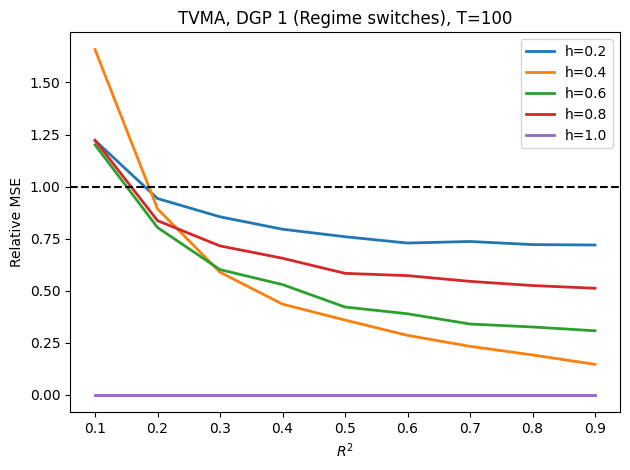

/tmp/ipykernel_961/3365770826.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


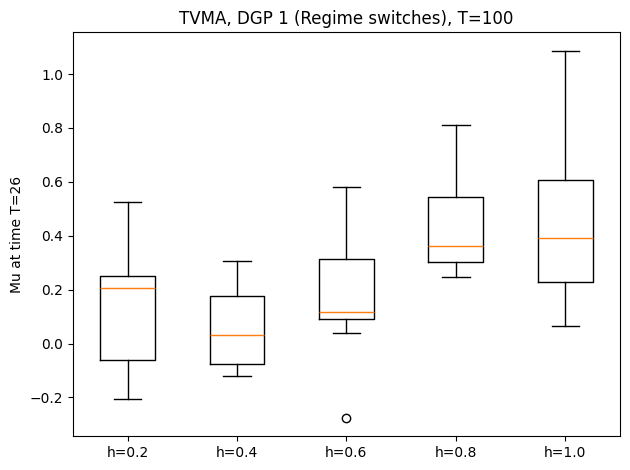

In [53]:

plt.plot(R2_grid, rel_mse_11, linewidth=2, label='h=0.2')
plt.plot(R2_grid, rel_mse_13, linewidth=2, label='h=0.4')
plt.plot(R2_grid, rel_mse_15, linewidth=2, label='h=0.6')
plt.plot(R2_grid, rel_mse_17, linewidth=2, label='h=0.8')
plt.plot(R2_grid, rel_mse_19, linewidth=2, label='h=1.0')


plt.axhline(1.0, linestyle="--", color="black")
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title(f"TVMA, DGP 1 (Regime switches), T={100}")
plt.legend()
plt.tight_layout()
plt.show()

data = [mu_11, mu_13, mu_15, mu_17, mu_19]
labels = ['h=0.2', 'h=0.4', 'h=0.6', 'h=0.8', 'h=1.0']

plt.figure()
plt.boxplot(data, labels=labels, showfliers=True)
plt.ylabel("Mu at time T=26")
plt.title(r"TVMA, DGP 1 (Regime switches), T=100")
plt.tight_layout()
plt.show()